### Goal

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt

### TODO: update this path

In [3]:
root = "/Users/michaelmoret/tinyverse/krap/data/24-12-05/triple/"

### From here; automatic run

In [4]:
for file in os.listdir(root):
    if file.endswith(".txt"):
        print(file)

20241205$25^EN_IHNY_bleached_AA_CTRL$25^ELI-1_AA*0.01$25^ELI-1_AA*0.03$25^ELI-1_AA*0.05$triple.txt
20241205$25^EN_IHNY_bleached_ELI-1_Phos_control$25^ELI-1_Phos*0.01$25^ELI-1_Phos*0.03$25^ELI-1_Phos*0.05$single.txt


In [5]:
savepath = f"{root}plots/"
os.makedirs(savepath, exist_ok=True)

In [6]:
all_dfs = []
for file in os.listdir(root):
    if file.endswith(".txt"):
        df = pd.read_csv(root + file, sep="\t")
        splitted_name = file.split("$")
        # get the experiments; i.e. not the date
        # not the single or triple
        splitted_name = splitted_name[1:-1]
        # add the experiment name in the dataframe
        all_names = []
        for entries in splitted_name:
            times_name = entries.split("^")
            _times = int(times_name[0])
            _name = times_name[1]
            all_names += [_name] * _times
        df["Name"] = all_names
        # remove nan
        df = df.dropna()
        all_dfs.append(df)
        
# merge df
df_merged = pd.concat(all_dfs)
df_merged.head(5)

,RECORD,CROSS-SECTIONAL AREA,MEAN DIAMETER,MAX DIAMETER,MIN DIAMETER,ELASTIC EMOD,ELASTIC GRADIENT,ELASTIC EXT,ELASTIC STRESS,PLATEAU LOAD,...,STRESS 25%,WORK 25%,YIELD EXT,POSTYIELD GRADIENT,BREAK EXT,BREAK LOAD,BREAK STRESS,TOTAL WORK,TOUGHNESS,Name
0,1,2963.2,63.9,73.2,51.5,3.826000e+09,38.06,3.06,0.01244,37.35,...,0.01266,0.002622,30.67,2.154,59.29,58.70,0.01981,0.007514,83530000.0,EN_IHNY_bleached_AA_CTRL
1,2,4200.6,73.7,81.0,66.2,3.823000e+09,53.91,3.06,0.01262,54.99,...,0.01365,0.003881,27.60,4.250,53.16,92.25,0.02196,0.010200,80010000.0,EN_IHNY_bleached_AA_CTRL
2,3,2919.4,62.8,71.2,52.1,4.400000e+09,42.90,2.56,0.01187,37.08,...,0.01341,0.002643,26.93,2.198,52.36,54.50,0.01867,0.006378,71580000.0,EN_IHNY_bleached_AA_CTRL
3,4,4667.4,79.4,97.0,61.2,3.758000e+09,59.13,3.47,0.01254,61.67,...,0.01404,0.004303,22.69,4.212,42.96,88.00,0.01885,0.008311,58880000.0,EN_IHNY_bleached_AA_CTRL
4,5,3832.7,70.0,77.7,62.8,3.676000e+09,47.33,3.00,0.01241,48.35,...,0.01311,0.003450,25.94,3.404,50.00,73.90,0.01928,0.008010,68890000.0,EN_IHNY_bleached_AA_CTRL


## Helper Functions

In [7]:
import matplotlib.pyplot as plt
import scipy.stats
from itertools import combinations
import numpy as np

def create_boxplot(df, metric_column, group_column='Name', figsize=(10, 6)):
    """Create a compact boxplot with statistical test and median values"""
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Function to remove outliers
    def remove_outliers(data):
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return data[(data >= lower_bound) & (data <= upper_bound)]
    
    # Get unique base names and assign colors
    base_names = [name.split('*')[0] for name in df[group_column].unique()]
    unique_base_names = list(dict.fromkeys(base_names))  # Preserve order
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_base_names)))
    color_dict = dict(zip(unique_base_names, colors))
    
    # Create boxplot
    bp = ax.boxplot([df[df[group_column] == group][metric_column] for group in df[group_column].unique()],
                    patch_artist=True,
                    medianprops={'color': 'red', 'linewidth': 1.5},
                    boxprops={'color': 'black'},
                    whiskerprops={'color': 'black'},
                    capprops={'color': 'black'},
                    showfliers=False)
    
    # Color the boxes
    for patch, group_name in zip(bp['boxes'], df[group_column].unique()):
        base_name = group_name.split('*')[0]
        patch.set_facecolor(color_dict[base_name])
        patch.set_alpha(0.7)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Get unique groups
    group_names = df[group_column].unique()
    
    # Add median values and set x-tick labels
    ax.set_xticklabels(group_names, rotation=45, ha='right')
    
    for i, group in enumerate(group_names):
        median = df[df[group_column] == group][metric_column].median()
        ax.text(i+1, ax.get_ylim()[1]*1.02, f'Median: {round(median, 2)}',
                horizontalalignment='center', fontsize=9)
    
    # Perform pairwise Mann-Whitney U tests
    pairs = list(combinations(group_names, 2))
    
    for group1_name, group2_name in pairs:
        group1_data = df[df[group_column] == group1_name][metric_column]
        group2_data = df[df[group_column] == group2_name][metric_column]
        
        group1_clean = remove_outliers(group1_data)
        group2_clean = remove_outliers(group2_data)
        
        stat, p_value = scipy.stats.mannwhitneyu(group1_clean, group2_clean, alternative='two-sided')
        if p_value < 0.05:
            print(f"Statistical significance between {group1_name} and {group2_name}: p = {p_value:.4f}")
    
    plt.suptitle('')
    plt.title('')
    plt.xlabel(group_column, fontsize=10)
    plt.ylabel(metric_column.replace('_', ' ').title(), fontsize=10)
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    
    return fig, ax

In [8]:
df_merged.columns

Index(['RECORD', 'CROSS-SECTIONAL AREA', 'MEAN DIAMETER', 'MAX DIAMETER',
       'MIN DIAMETER', 'ELASTIC EMOD', 'ELASTIC GRADIENT', 'ELASTIC EXT',
       'ELASTIC STRESS', 'PLATEAU LOAD', 'PLATEAU STRESS', 'LOAD 15%',
       'STRESS 15%', 'WORK 15%', 'LOAD 25%', 'STRESS 25%', 'WORK 25%',
       'YIELD EXT', 'POSTYIELD GRADIENT', 'BREAK EXT', 'BREAK LOAD',
       'BREAK STRESS', 'TOTAL WORK', 'TOUGHNESS', 'Name'],
      dtype='object')

Statistical significance between EN_IHNY_bleached_AA_CTRL and ELI-1_AA*0.01: p = 0.0173
Statistical significance between EN_IHNY_bleached_AA_CTRL and ELI-1_AA*0.05: p = 0.0048
Statistical significance between EN_IHNY_bleached_AA_CTRL and EN_IHNY_bleached_ELI-1_Phos_control: p = 0.0008
Statistical significance between EN_IHNY_bleached_AA_CTRL and ELI-1_Phos*0.01: p = 0.0001
Statistical significance between EN_IHNY_bleached_AA_CTRL and ELI-1_Phos*0.03: p = 0.0001
Statistical significance between EN_IHNY_bleached_AA_CTRL and ELI-1_Phos*0.05: p = 0.0000
Statistical significance between ELI-1_AA*0.01 and ELI-1_Phos*0.03: p = 0.0142
Statistical significance between ELI-1_AA*0.01 and ELI-1_Phos*0.05: p = 0.0078
Statistical significance between ELI-1_AA*0.03 and ELI-1_Phos*0.01: p = 0.0259
Statistical significance between ELI-1_AA*0.03 and ELI-1_Phos*0.03: p = 0.0063
Statistical significance between ELI-1_AA*0.03 and ELI-1_Phos*0.05: p = 0.0014
Statistical significance between ELI-1_AA*0.05 an

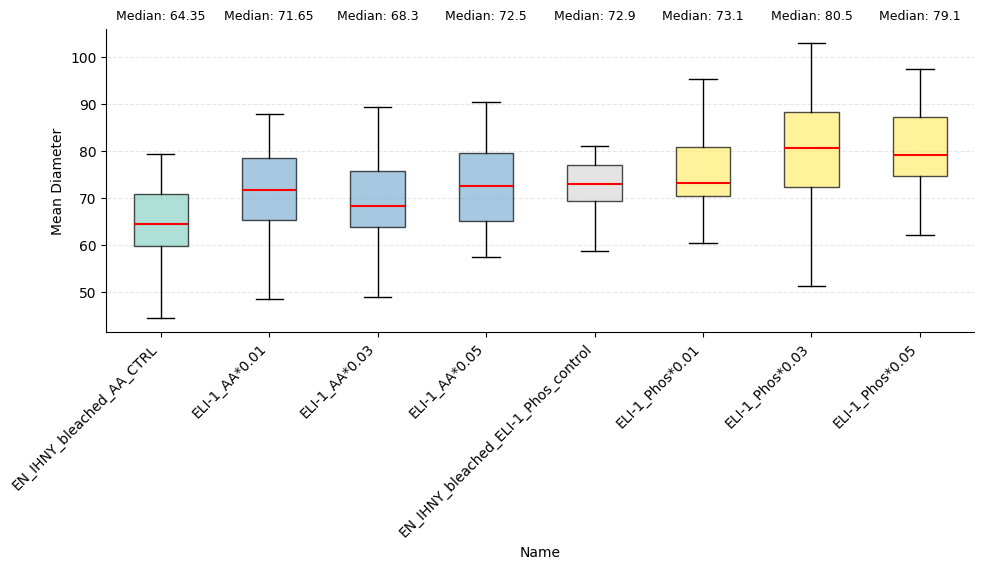

In [9]:
header = 'MEAN DIAMETER'
fig, ax = create_boxplot(df_merged, header)
fig.savefig(f"{savepath}{header}.png")
plt.show()

In [10]:
len(df_merged)

185

Statistical significance between EN_IHNY_bleached_AA_CTRL and ELI-1_Phos*0.05: p = 0.0229
Statistical significance between ELI-1_AA*0.03 and ELI-1_AA*0.05: p = 0.0292
Statistical significance between ELI-1_AA*0.03 and EN_IHNY_bleached_ELI-1_Phos_control: p = 0.0170
Statistical significance between ELI-1_AA*0.05 and ELI-1_Phos*0.05: p = 0.0102
Statistical significance between EN_IHNY_bleached_ELI-1_Phos_control and ELI-1_Phos*0.05: p = 0.0073


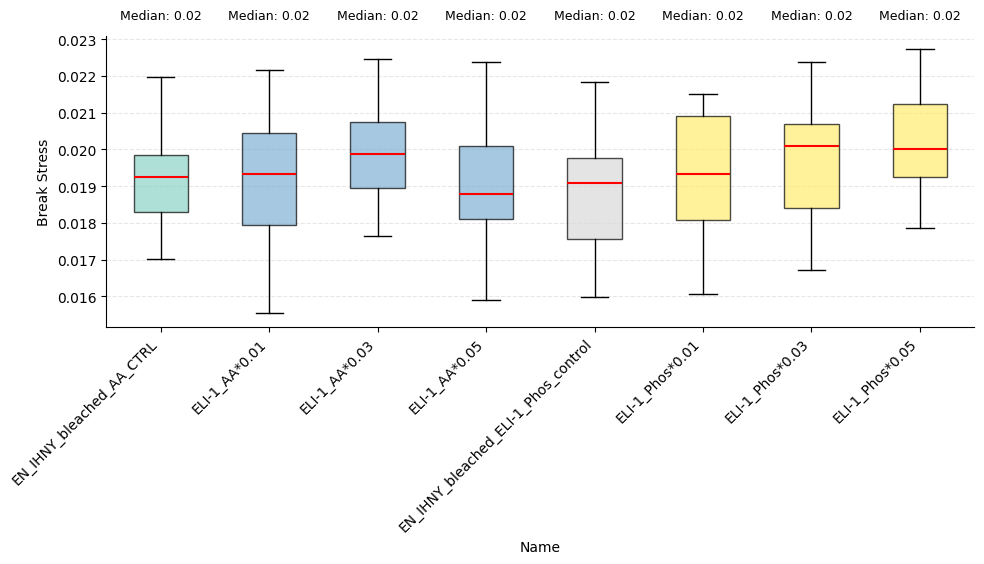

In [11]:
header = 'BREAK STRESS'
fig, ax = create_boxplot(df_merged, header)
fig.savefig(f"{savepath}{header}.png")
plt.show()

Statistical significance between EN_IHNY_bleached_AA_CTRL and EN_IHNY_bleached_ELI-1_Phos_control: p = 0.0227
Statistical significance between EN_IHNY_bleached_ELI-1_Phos_control and ELI-1_Phos*0.05: p = 0.0166


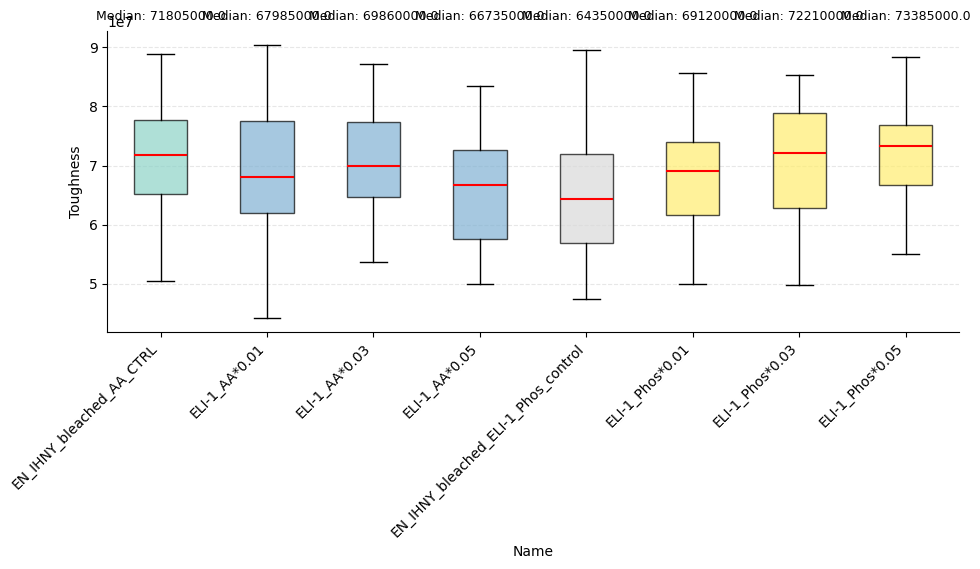

In [12]:
header = 'TOUGHNESS'
fig, ax = create_boxplot(df_merged, header)
fig.savefig(f"{savepath}{header}.png")
plt.show()

Statistical significance between EN_IHNY_bleached_AA_CTRL and ELI-1_Phos*0.03: p = 0.0367
Statistical significance between ELI-1_AA*0.05 and ELI-1_Phos*0.03: p = 0.0253


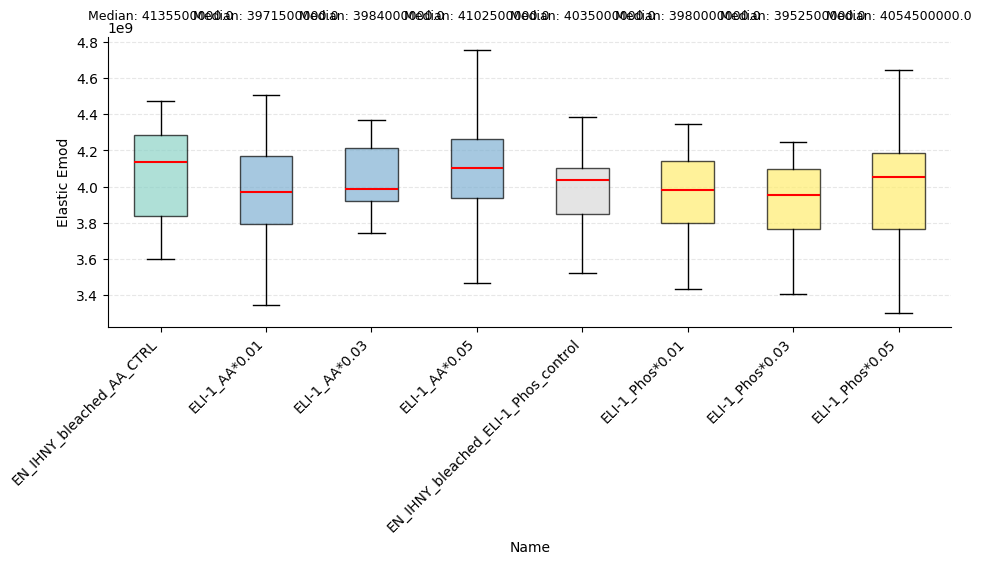

In [13]:
header = 'ELASTIC EMOD'
fig, ax = create_boxplot(df_merged, header)
fig.savefig(f"{savepath}{header}.png")
plt.show()